# Analyse time-dependent proteome

## 1. Load data into workbook

In [1]:
import cPickle as pkl
import re
import random
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import bokeh
import collections
from statsmodels.nonparametric.smoothers_lowess import lowess

Write part of the directory listing to a variable:

In [2]:
import platform
if platform.system()=="Windows":
    files = !dir ..\results\pol*
else:
    files = !ls ../results/pol*

Set up a dictionary that contains the simulation results.

In [3]:
filepaths = {}
for file in files:
    match = re.search(r'from (\w+)', file)
    if match:
        if platform.system()=="Windows":
            filepaths[int(match.group(1).zfill(4))] = r"..\\results\\" + file[file.index("polyphasic"):]
            # because the output of dir is more complex than that of ls
        else:
            filepaths[int(match.group(1).zfill(4))] = file

Function to replace _numpypy.multiarray by numpy.core.multiarray. Source: http://stackoverflow.com/questions/39086/search-and-replace-a-line-in-a-file-in-python

In [4]:
from tempfile import mkstemp
from shutil import move
from os import remove, close

def replace(file_path, pattern, subst):
    #Create temp file
    fh, abs_path = mkstemp()
    with open(abs_path,'w') as new_file:
        with open(file_path) as old_file:
            for line in old_file:
                new_file.write(line.replace(pattern, subst))
    close(fh)
    #Remove original file
    remove(file_path)
    #Move new file
    move(abs_path, file_path)

Port from Pypy to Python:

In [52]:
for time in filepaths:
    print time,
    replace(filepaths[time], "_numpypy.multiarray", "numpy.core.multiarray")

0 2400 3300 1800 300 2700 1200 600 2100 3000 900 1500


Create proteome dictionary:

In [5]:
results = {}
proteome = {}
for time in filepaths:
    print time, filepaths[time]
    results[time] = pkl.load(open(filepaths[time]))
    proteome[time] = {key: results[time]['proteome'][key] for key in results[time]['proteome'] 
                     if results[time]['proteome'][key] > 1e-1}

0 ../results/polyphasic cell cycle from 0 to 300, updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah_20160212_1719_1200s.p
2400 ../results/polyphasic cell cycle from 2400 to 2700, updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah_20160212_2026_1200s.p
3300 ../results/polyphasic cell cycle from 3300 to 3600, updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah_20160212_2142_1200s.p
1800 ../results/polyphasic cell cycle from 1800 to 2100, updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah_20160212_1934_1200s.p
300 ../results/polyphasic cell cycle from 300 to 600, updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah_20160212_1736_1200s.p
2700 ../results/polyphasic cell cycle from 2700 to 3000, updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah_

## 2. Test whether burn-in period has been long enough

Plot timecourses:

In [6]:
time = 300
protnames = results[time]['timecourses'].keys()
size = 5
protnames_plot = np.array(random.sample(protnames, size*size))
protnames_plot.shape = (size, size)

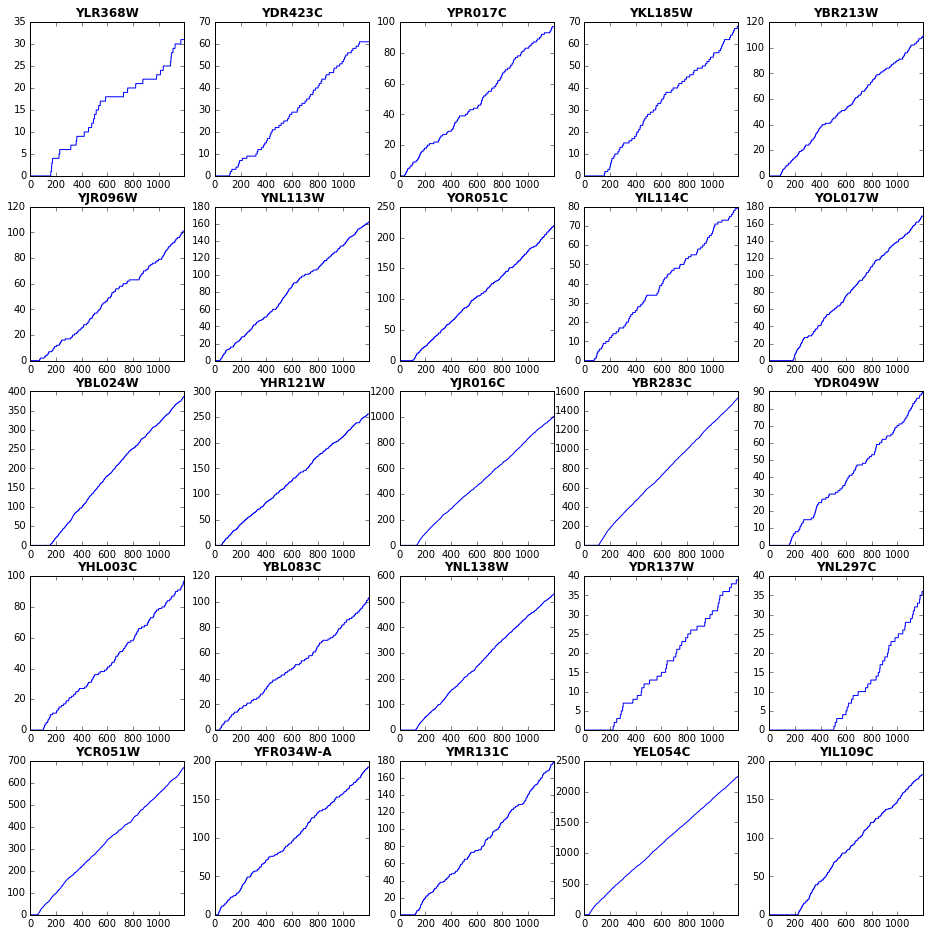

In [7]:
fig, ax = plt.subplots(size, size, figsize=(16, 16))

for i in range(size):
    for j in range(size):
        yseries = results[time]['timecourses'][protnames_plot[i][j]]
        xseries = np.arange(0., float(len(yseries)), 1.)
        # oddly, sometimes the simulation sometimes 'loses' one data point
        length = min(len(xseries), len(yseries))
        ax[i, j].plot(xseries[:length], yseries[:length])
        ax[i, j].set_xticks(np.arange(min(xseries), max(xseries)+1, 200.0))
        ax[i, j].set_title(protnames_plot[i][j], fontdict={'fontsize': 12, 'fontweight': 'bold'})
        ax[i, j].tick_params(axis='both', which='major', labelsize=10)

Plot increases and check for saturation of "first derivative":

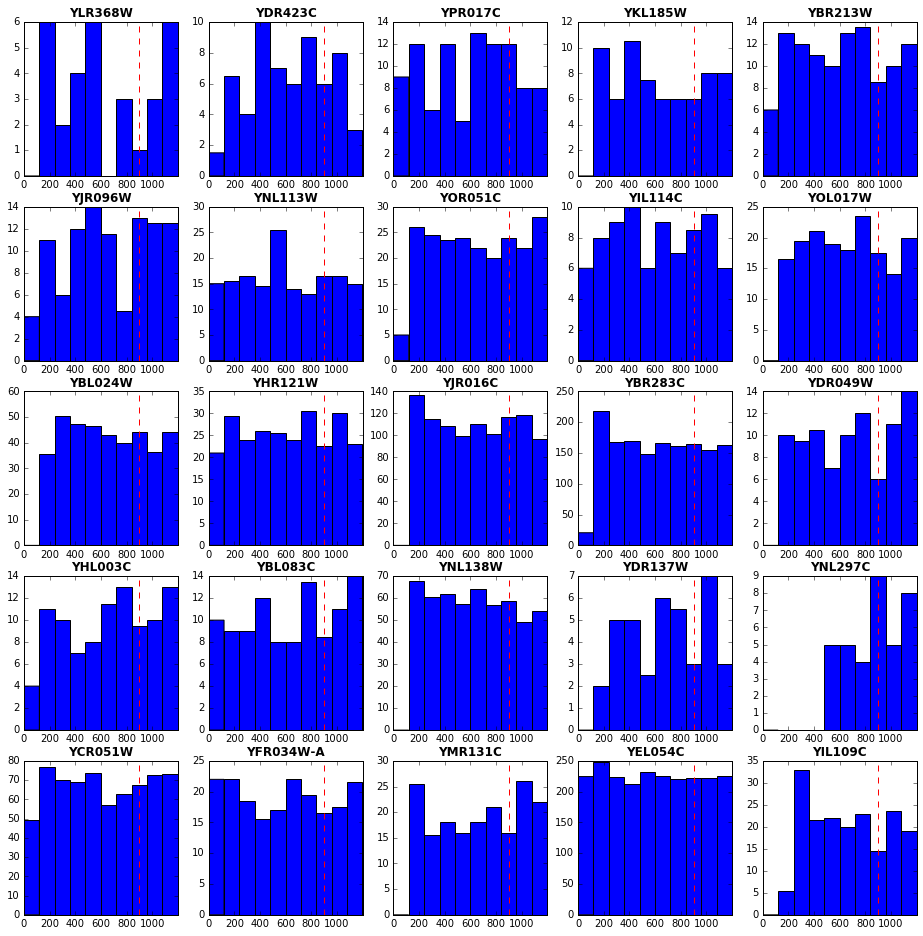

In [8]:
burnin = len(yseries) - 300  # 300 s simulation, rest is burn-in
fig, ax = plt.subplots(size, size, figsize=(16, 16))

for i in range(size):
    for j in range(size):
        yseries = results[time]['timecourses'][protnames_plot[i][j]]
        dy = np.gradient(yseries)
        xseries = np.arange(0., float(len(dy)), 1.)
        # oddly, sometimes the simulation sometimes 'loses' one data point
        length = min(len(xseries), len(yseries))
        ax[i, j].hist(xseries, bins=10, weights=dy)
        ax[i, j].axvline(burnin, color='red', linestyle='--')
        ax[i, j].set_xticks(np.arange(min(xseries), max(xseries)+1, 200.0))
        ax[i, j].set_title(protnames_plot[i][j], fontdict={'fontsize': 12, 'fontweight': 'bold'})
        ax[i, j].tick_params(axis='both', which='major', labelsize=10)

## 3. Plot proteomes at different times

In [9]:
def scatter_dicts(dict1, dict2, xaxislabel=None, yaxislabel=None, fontsize=None, lws=True):
    plotkeys = dict1.viewkeys() & dict2.viewkeys() # set intersection
    print len(plotkeys)
    xs = [dict1[key] for key in plotkeys]
    ys = [dict2[key] for key in plotkeys] 

    #fig =  plt.figure()                

    ax = fig.add_subplot(111)
    ax.grid(True, linestyle = '-', color = '0.75')
    ax.set_xscale('log')
    ax.set_yscale('log')
    if xaxislabel:
        ax.set_xlabel(xaxislabel)
        if fontsize:
            ax.set_xlabel(xaxislabel, fontsize=fontsize)
            plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    if yaxislabel:
        ax.set_ylabel(yaxislabel)
        if fontsize:
            ax.set_ylabel(yaxislabel, fontsize=fontsize)
            plt.setp(ax.get_yticklabels(), fontsize=fontsize)

    scat = plt.scatter(xs, ys)
    scat.set_alpha(0.2)
    
    # turn on lowess plott
    if lws:
        points = zip(xs, ys)
        sorted_points = sorted(points)
        new_xs = [point[0] for point in sorted_points]
        new_ys = [point[1] for point in sorted_points]
        ylowess = lowess(new_ys, new_xs)[:,1]
        plt.plot(new_xs, ylowess, 'orange', linewidth=4)

    #plt.show()

Prevent output from scrolling:

In [10]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 999;

<IPython.core.display.Javascript object>

3531


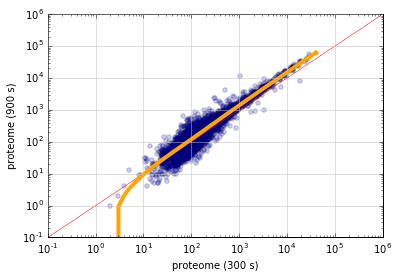

3535


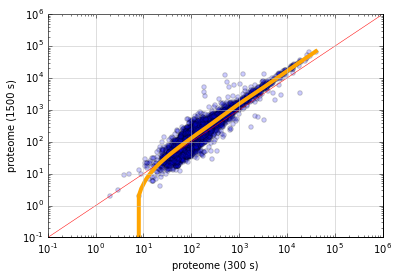

3564


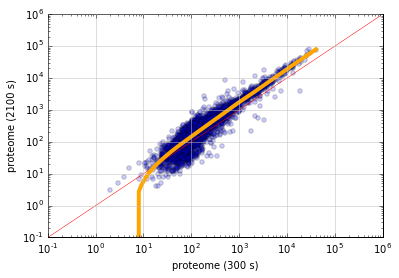

4612


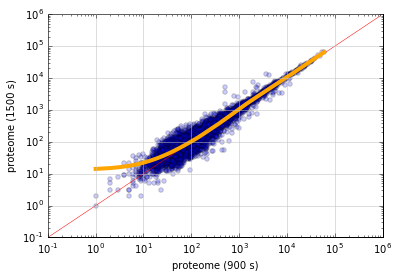

4727


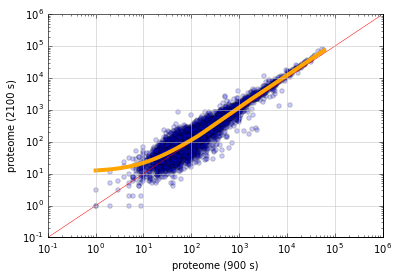

4776


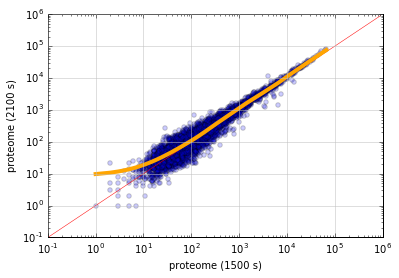

In [61]:
times = np.arange(0, 3600, 600)[:4]
#rows = len(times/columns)
for i, tx in enumerate(times):
    #fig, ax = plt.subplots(rows, columns, figsize=(16, 16))
    for ty in times[i+1:]:
        fig =  plt.figure()                
        plt.plot([1e-1, 1e6-100000], [1e-1, 1e6-100000], color='red', linestyle='-', linewidth=0.5)
        scatter_dicts(proteome[tx], proteome[ty], xaxislabel="proteome ({} s)".format(tx+300), 
                      yaxislabel="proteome ({} s)".format(ty+300), fontsize=None)
        plt.show()

## 4. Plot translational impact

First we check whether the relevant genes are in our data set.

Histones from http://wcmwiki.pbworks.com/w/page/103620021/20151208_Histones:

In [12]:
len(results[time]['timecourses'].keys())

3611

In [13]:
histones = ['YDR224C', 'YBL002W', 'YDR225W', 'YBL003C', 'YOL012C', 'YBR009C', 'YNL030W', 'YBR010W', 'YNL031C', 'YPL127C']

In [14]:
for histone in histones:
    print "Histone {} found in data set: {}".format(histone, histone in results[time]['timecourses'])

Histone YDR224C found in data set: True
Histone YBL002W found in data set: True
Histone YDR225W found in data set: True
Histone YBL003C found in data set: True
Histone YOL012C found in data set: True
Histone YBR009C found in data set: True
Histone YNL030W found in data set: True
Histone YBR010W found in data set: True
Histone YNL031C found in data set: True
Histone YPL127C found in data set: True


Transcription factors from https://bitbucket.org/wcm-team/gene_regulation/src/2cc7fcaefff9cd5ec89783253b281cebfbb88d32/model/input.py?at=master&fileviewer=file-view-default:

In [15]:
TFs = ["YNL027W", "YLR113W", "YMR174W", "YER062C", "YHR084W", "YDL056W", "YLR182W", "YER111C", "YLR118W", "YMR043W"]

In [16]:
for TF in TFs:
    print "TF {} found in data set: {}".format(TF, TF in results[time]['timecourses'])

TF YNL027W found in data set: True
TF YLR113W found in data set: True
TF YMR174W found in data set: False
TF YER062C found in data set: True
TF YHR084W found in data set: False
TF YDL056W found in data set: True
TF YLR182W found in data set: True
TF YER111C found in data set: True
TF YLR118W found in data set: False
TF YMR043W found in data set: True


Get mRNAs:

In [17]:
transcriptomes_dict = collections.OrderedDict(sorted(
        pkl.load((open('../parameters/transcriptome_time_dependent.p'))).items()))

In [18]:
transcriptomes_dict.keys()

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]

In [19]:
absolute_transcript_count = {time: sum(transcriptomes_dict[time].values()) for time in sorted(transcriptomes_dict.keys())}

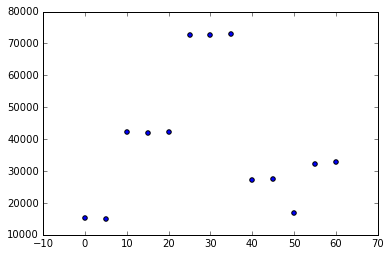

In [20]:
plt.scatter(absolute_transcript_count.keys(), absolute_transcript_count.values(), marker='o')

TODO: this can be made look nicer for sure.

Generate fold-changes for transcriptome:

In [21]:
time = 30 * 60

In [22]:
print len(transcriptomes_dict[time/60])
print len(transcriptomes_dict[0])

6651
6651


In [23]:
print transcriptomes_dict.keys()
print len(results[2400]['timecourses'].keys())  # some proteins were not translated (probably no transcripts)

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
4332


First we try only one pair of times:

In [24]:
time_0 = 0
time_t = 30 * 60  # time always in seconds

In [67]:
def transcriptome_fold_change(time_0, time_t):
    tmp = {}
    for gene in transcriptomes_dict[time_0/60]:
        if gene in transcriptomes_dict[time_t/60] and transcriptomes_dict[time_0/60][gene] != 0 and \
        transcriptomes_dict[time_t/60][gene] != 0:
            tmp[gene] = np.log2(1.0 * transcriptomes_dict[time_t/60][gene]/transcriptomes_dict[time_0/60][gene])
    return tmp

In [69]:
len(transcriptome_fold_change(time_0, time_t))

3567

In [70]:
def proteome_fold_change(time_0, time_t):
    tmp = {}
    for gene in results[time_0]['timecourses']:
        if gene in results[time_t]['timecourses'] and results[time_0]['timecourses'][gene][-1] != 0 and \
        results[time_t]['timecourses'][gene][-1] != 0:
            tmp[gene] = np.log2(1.0 * results[time_t]['timecourses'][gene][-1]/results[time_0]['timecourses'][gene][-1])
    return tmp

In [72]:
len(proteome_fold_change(time_0, time_t))

3615

In [73]:
def scatter_dicts_interactive(dict1,  dict2, xaxislabel=None, yaxislabel=None, fontsize=None):
    from bokeh.plotting import figure, show, ColumnDataSource
    from bokeh.models import HoverTool
    from bokeh.io import output_notebook
    
    plotkeys = list(dict1.viewkeys() & dict2.viewkeys()) # set intersection
    xs = [dict1[key] for key in plotkeys]
    ys = [dict2[key] for key in plotkeys] 

    plt.close()
    output_notebook()

    source = ColumnDataSource(data=dict(x=xs, y=ys, desc=plotkeys, ))

    hover = HoverTool(
            tooltips=[
                #("index", "$index"),
                #("(x,y)", "($x, $y)"),
                ("", "@desc"),
            ]
        )

    p = figure(plot_width=600, plot_height=600, tools=[hover,"wheel_zoom,box_zoom,reset"],
               #x_axis_type="log", 
               x_range=[0.8*min(xs), max(xs)/0.8], 
               #y_axis_type="log", 
               y_range=[0.8*min(ys), max(ys)/0.8], 
               title="",)
    p.xaxis.axis_label = xaxislabel
    p.yaxis.axis_label = yaxislabel
    p.xaxis.axis_label_text_font_size = "10pt"
    p.yaxis.axis_label_text_font_size = "10pt"
    p.scatter('x', 'y', size=5, source=source, fill_color=None, line_alpha=0.5, line_color='green')

    show(p)

In [77]:
times = [0, 300, 600]
for i, tx in enumerate(times):
    #fig, ax = plt.subplots(rows, columns, figsize=(16, 16))
    for ty in times[i+1:]:
        scatter_dicts_interactive(transcriptome_fold_change(time_0, time_t), proteome_fold_change(time_0, time_t),
                                  "transcript abundance (fold change) ("+str(tx)+" s)", 
                                  "proteome abundance (fold change) ("+str(ty)+" s)")

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

## 5. Analysis for WCM_GRN (abundant periodic genes found by Katja)

In [33]:
genes_shortlist = {'HHF1': 'YBR009C', 'HHF2': 'YNL030W', 'HHT1': 'YBR010W', 'HHT2': 'YNL031C', 'HTB1': 'YDR224C', 
                   'HTB2': 'YBL002W', 'PMA1': 'YGL008C', 'RNR1': 'YER070W', 'RNR2': 'YJL026W', 'RNR3': 'YIL066C', 
                   'RNR4': 'YGR180C'}

In [34]:
translation_rate_shortlist = {}

for (genecommon, gene) in genes_shortlist.items():
    translation_rate_shortlist[genecommon] = []
    for time in np.arange(0, 3600, 300):
        if gene in results[time]['timecourses']:
            rate = float(results[time]['timecourses'][gene][-1]-results[time]['timecourses'][gene][-301])/300.
        else:
            rate = 0.
        translation_rate_shortlist[genecommon].append(rate)

In [35]:
translation_ratedf = pd.DataFrame(translation_rate_shortlist, index=np.arange(0, 3600, 300))

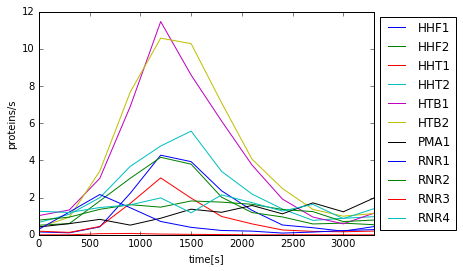

In [36]:
pl = translation_ratedf.plot()
pl.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
pl.set_xlabel("time[s]")
pl.set_ylabel("proteins/s")

In [37]:
translation_ratedf

HHF1      HHF2      HHT1      HHT2       HTB1       HTB2      PMA1  \
0     0.153333  0.516667  0.193333  0.666667   1.033333   0.400000  0.423333   
300   0.106667  0.603333  0.130000  1.103333   1.336667   0.946667  0.600000   
600   0.426667  1.820000  0.446667  1.996667   3.036667   3.426667  0.830000   
900   2.233333  3.040000  1.690000  3.680000   6.900000   7.673333  0.520000   
1200  4.280000  4.166667  3.060000  4.773333  11.463333  10.573333  0.890000   
1500  3.933333  3.796667  1.970000  5.576667   8.586667  10.276667  1.376667   
1800  2.366667  2.023333  0.986667  3.410000   6.116667   7.096667  1.210000   
2100  1.313333  1.196667  0.586667  2.190000   3.753333   4.066667  1.576667   
2400  0.526667  0.960000  0.260000  1.386667   1.920000   2.486667  1.126667   
2700  0.380000  0.583333  0.183333  0.776667   0.953333   1.366667  1.716667   
3000  0.193333  0.626667  0.163333  0.886667   0.590000   1.000000  1.236667   
3300  0.440000  0.543333  0.200000  0.976667   1.160000   1.143333  1.973333   

          RNR1      RNR2      RNR3      RNR4  
0     0.300000  0.790000  0.000000  1.266667  
300   1.223333  0.950000  0.000000  1.200000  
600   2.166667  1.370000  0.060000  1.466667  
900   1.453333  1.620000  0.073333  1.610000  
1200  0.716667  1.486667  0.040000  1.983333  
1500  0.400000  1.820000  0.023333  1.183333  
1800  0.233333  1.756667  0.013333  2.146667  
2100  0.196667  1.640000  0.000000  1.730000  
2400  0.093333  1.360000  0.000000  1.276667  
2700  0.146667  1.246667  0.000000  1.636667  
3000  0.226667  0.710000  0.000000  0.870000  
3300  0.280000  0.793333  0.000000  1.400000

In [38]:
transcriptome_df = pd.DataFrame(transcriptomes_dict).transpose()
del transcriptome_df[0]
transcriptome_df.index = np.arange(0, 3601, 300)
transcriptome_df

Q0010  Q0017  Q0032  Q0045  Q0050  Q0055  Q0060  Q0065  Q0070  Q0075  \
0         0      0      0      0      0      0      0      0      0      0   
300       0      0      0      0      0      0      0      0      0      0   
600       0      0      0      0      0      0      0      0      0      0   
900       0      0      0      0      0      0      0      0      0      0   
1200      0      0      0      0      0      0      0      0      0      0   
1500      0      0      0      0      0      0      0      0      0      0   
1800      0      0      0      0      0      0      0      0      0      0   
2100      0      0      0      0      0      0      0      0      0      0   
2400      0      0      0      0      0      0      0      0      0      0   
2700      0      0      0      0      0      0      0      0      0      0   
3000      0      0      0      0      0      0      0      0      0      0   
3300      0      0      0      0      0      0      0      0      0      0   
3600      0      0      0      0      0      0      0      0      0      0   

       ...     YPR196W  YPR197C  YPR198W  YPR199C  YPR200C  YPR201W  YPR202W  \
0      ...           0        0        0        0        0        0        0   
300    ...           0        0        1        0        0        0        0   
600    ...           0        0        1        0        1        0        0   
900    ...           0        0        2        1        0        0        0   
1200   ...           0        0        1        1        1        0        0   
1500   ...           1        0        2        1        0        0        0   
1800   ...           0        0        2        2        0        0        0   
2100   ...           0        0        2        1        0        0        0   
2400   ...           0        0        1        1        0        0        0   
2700   ...           0        0        1        1        0        0        0   
3000   ...           0        0        0        0        0        0        0   
3300   ...           0        0        1        2        0        0        0   
3600   ...           0        0        1        1        0        0        0   

      YPR203W  YPR204C-A  YPR204W  
0           0          0        0  
300         0          0        0  
600         0          0        0  
900         0          0        0  
1200        0          0        0  
1500        0          0        0  
1800        0          0        0  
2100        0          0        0  
2400        0          0        0  
2700        0          0        0  
3000        0          0        0  
3300        0          0        0  
3600        0          0        0  

[13 rows x 6650 columns]

In [39]:
transcriptome_df_short = transcriptome_df[transcriptome_df.index<3600][genes_shortlist.values()]

In [40]:
transcriptome_df_short.columns = genes_shortlist.keys()
transcriptome_df_short

HTB2  HTB1  HHF1  HHF2  PMA1  RNR2  RNR3  HHT2  RNR1  RNR4  HHT1
0        2     4     2     7     3     5     0     8     3     7     2
300      4     5     1     8     4     6     0    13    12     7     2
600     27    18    10    50    10    16     1    55    46    15    12
900     58    41    55    77     6    18     2    97    29    15    42
1200    77    65   106   107    11    16     1   119    14    19    70
1500   113    68   152   152    24    30     1   232    12    17    81
1800    75    48    91    81    22    29     1   141     6    29    40
2100    44    28    47    46    28    27     0    81     5    23    23
2400    12     8     8    15     8    10     0    20     1     8     4
2700     7     4     6     9    12     9     0    11     2    10     3
3000     4     2     2     6     7     4     0     9     2     4     2
3300     6     5     6     8    15     6     0    16     3     9     3

In [41]:
translation_rate_per_mrna = translation_ratedf/transcriptome_df_short

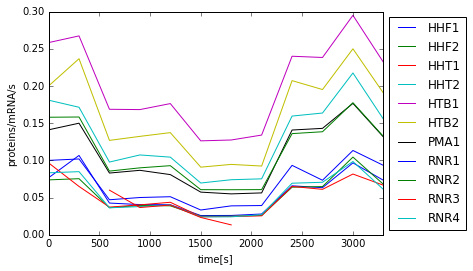

In [42]:
pl = translation_rate_per_mrna.plot()
pl.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
pl.set_xlabel("time[s]")
pl.set_ylabel("proteins/mRNA/s")

In [43]:
translation_rate_per_mrna

HHF1      HHF2      HHT1      HHT2      HTB1      HTB2      PMA1  \
0     0.076667  0.073810  0.096667  0.083333  0.258333  0.200000  0.141111   
300   0.106667  0.075417  0.065000  0.084872  0.267333  0.236667  0.150000   
600   0.042667  0.036400  0.037222  0.036303  0.168704  0.126914  0.083000   
900   0.040606  0.039481  0.040238  0.037938  0.168293  0.132299  0.086667   
1200  0.040377  0.038941  0.043714  0.040112  0.176359  0.137316  0.080909   
1500  0.025877  0.024978  0.024321  0.024037  0.126275  0.090944  0.057361   
1800  0.026007  0.024979  0.024667  0.024184  0.127431  0.094622  0.055000   
2100  0.027943  0.026014  0.025507  0.027037  0.134048  0.092424  0.056310   
2400  0.065833  0.064000  0.065000  0.069333  0.240000  0.207222  0.140833   
2700  0.063333  0.064815  0.061111  0.070606  0.238333  0.195238  0.143056   
3000  0.096667  0.104444  0.081667  0.098519  0.295000  0.250000  0.176667   
3300  0.073333  0.067917  0.066667  0.061042  0.232000  0.190556  0.131556   

          RNR1      RNR2      RNR3      RNR4  
0     0.100000  0.158000       NaN  0.180952  
300   0.101944  0.158333       NaN  0.171429  
600   0.047101  0.085625  0.060000  0.097778  
900   0.050115  0.090000  0.036667  0.107333  
1200  0.051190  0.092917  0.040000  0.104386  
1500  0.033333  0.060667  0.023333  0.069608  
1800  0.038889  0.060575  0.013333  0.074023  
2100  0.039333  0.060741       NaN  0.075217  
2400  0.093333  0.136000       NaN  0.159583  
2700  0.073333  0.138519       NaN  0.163667  
3000  0.113333  0.177500       NaN  0.217500  
3300  0.093333  0.132222       NaN  0.155556

In [44]:
translation_rate_per_mrna.to_csv('translation_rate_per_mrna.csv')

Comparison with initiation probabilities:translation_rate_per_mrna

In [45]:
init_rates = pkl.load(open("../parameters/init_rates_enhanced_median.p", "rb"))
init_rates_common = {gene: init_rates[genes_shortlist[gene]]*1e6 for gene in genes_shortlist}

11


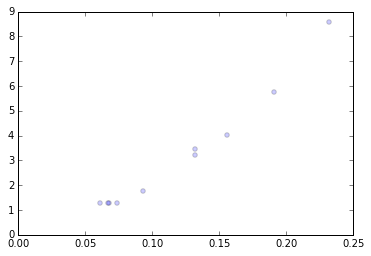

In [46]:
scatter_dicts(dict(translation_rate_per_mrna.ix[3300]), init_rates_common, xaxislabel='translation rate per transcript', 
              yaxislabel='initiation rate * 1E6', lws=False)

In [47]:
init_rates_common

{'HHF1': 1.291871859830537,
 'HHF2': 1.291871859830537,
 'HHT1': 1.291871859830537,
 'HHT2': 1.291871859830537,
 'HTB1': 8.580451211929118,
 'HTB2': 5.738927640019162,
 'PMA1': 3.2253823872000513,
 'RNR1': 1.7477148350729443,
 'RNR2': 3.4541884421416924,
 'RNR3': 1.1468920259159536,
 'RNR4': 4.039182074735152}

## 6. Translational efficiency by initiation probability

Load unadjusted initiation probabilites:

In [48]:
init_rates = pkl.load(open("../parameters/init_rates_plotkin.p", "rb"))

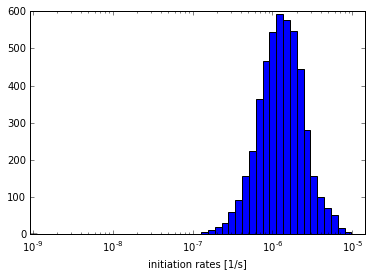

In [49]:
plt.hist(init_rates.values(), bins = 10**np.linspace(np.log10(min(init_rates.values())), 
                                                              np.log10(max(init_rates.values())), num=50))
plt.gca().set_xscale("log")
plt.gca().set_xlim([min(init_rates.values()), max(init_rates.values())])
plt.gca().set_xlabel('initiation rates [1/s]')
plt.show()

In [50]:
translation_rate = {}

for gene in init_rates:
    translation_rate[gene] = []
    for time in np.arange(0, 3600, 300):
        if gene in results[time]['timecourses']:
            rate = float(results[time]['timecourses'][gene][-1]-results[time]['timecourses'][gene][-301])/300.
        else:
            rate = 0.
        translation_rate[gene].append(rate)

In [51]:
translation_rate_df = pd.DataFrame(translation_rate)
translation_rate_df.index = np.arange(0, 3600, 300)
translation_rate_df['time'] = translation_rate_df.index
translation_rate_df

YAL001C   YAL002W    YAL003W   YAL007C   YAL008W   YAL009W   YAL010C  \
0     0.000000  0.006667   4.343333  0.093333  0.166667  0.040000  0.000000   
300   0.043333  0.000000   3.533333  0.113333  0.156667  0.000000  0.000000   
600   0.036667  0.013333   6.313333  0.343333  0.326667  0.030000  0.000000   
900   0.036667  0.016667   7.360000  0.290000  0.230000  0.033333  0.033333   
1200  0.033333  0.003333   7.493333  0.270000  0.156667  0.050000  0.000000   
1500  0.020000  0.016667   9.500000  0.280000  0.230000  0.086667  0.000000   
1800  0.036667  0.020000   9.920000  0.310000  0.150000  0.106667  0.013333   
2100  0.020000  0.040000  10.583333  0.346667  0.106667  0.053333  0.030000   
2400  0.040000  0.036667   5.700000  0.226667  0.143333  0.123333  0.000000   
2700  0.026667  0.006667   9.623333  0.093333  0.140000  0.030000  0.000000   
3000  0.000000  0.000000   6.126667  0.140000  0.153333  0.073333  0.000000   
3300  0.036667  0.013333   9.453333  0.306667  0.000000  0.043333  0.000000   

       YAL011W   YAL012W   YAL013W  ...    YPR185W   YPR186C   YPR187W  \
0     0.000000  4.550000  0.110000  ...   0.000000  0.000000  0.633333   
300   0.000000  4.153333  0.110000  ...   0.053333  0.000000  0.540000   
600   0.023333  6.920000  0.126667  ...   0.013333  0.016667  0.820000   
900   0.063333  6.626667  0.183333  ...   0.020000  0.036667  0.846667   
1200  0.036667  6.100000  0.206667  ...   0.020000  0.033333  1.116667   
1500  0.016667  6.230000  0.133333  ...   0.026667  0.083333  0.886667   
1800  0.056667  7.006667  0.163333  ...   0.020000  0.036667  0.800000   
2100  0.040000  7.170000  0.180000  ...   0.013333  0.020000  1.073333   
2400  0.000000  5.720000  0.196667  ...   0.000000  0.070000  1.150000   
2700  0.070000  7.060000  0.113333  ...   0.036667  0.000000  1.193333   
3000  0.000000  4.083333  0.126667  ...   0.060000  0.000000  1.060000   
3300  0.046667  7.136667  0.193333  ...   0.020000  0.046667  1.276667   

       YPR188C   YPR189W   YPR190C   YPR191W   YPR198W   YPR199C  time  
0     0.080000  0.063333  0.063333  0.093333  0.000000  0.000000     0  
300   0.093333  0.066667  0.063333  0.123333  0.103333  0.000000   300  
600   0.073333  0.060000  0.066667  0.140000  0.050000  0.000000   600  
900   0.240000  0.073333  0.070000  0.076667  0.096667  0.013333   900  
1200  0.180000  0.020000  0.203333  0.116667  0.033333  0.020000  1200  
1500  0.146667  0.080000  0.043333  0.100000  0.053333  0.010000  1500  
1800  0.100000  0.076667  0.076667  0.086667  0.046667  0.016667  1800  
2100  0.133333  0.086667  0.120000  0.123333  0.040000  0.006667  2100  
2400  0.063333  0.143333  0.036667  0.086667  0.086667  0.030000  2400  
2700  0.183333  0.066667  0.090000  0.173333  0.063333  0.023333  2700  
3000  0.000000  0.090000  0.106667  0.133333  0.000000  0.000000  3000  
3300  0.170000  0.136667  0.096667  0.100000  0.056667  0.070000  3300  

[12 rows x 4840 columns]

In [52]:
bins = 10**np.linspace(np.log10(min(init_rates.values())), np.log10(max(init_rates.values())), num=50)
bins

array([  9.37576635e-10,   1.14142282e-09,   1.38958888e-09,
         1.69171074e-09,   2.05951938e-09,   2.50729629e-09,
         3.05242805e-09,   3.71608134e-09,   4.52402492e-09,
         5.50763011e-09,   6.70508892e-09,   8.16289703e-09,
         9.93765910e-09,   1.20982867e-08,   1.47286739e-08,
         1.79309552e-08,   2.18294705e-08,   2.65755938e-08,
         3.23536106e-08,   3.93878732e-08,   4.79515122e-08,
         5.83770419e-08,   7.10692710e-08,   8.65210213e-08,
         1.05332263e-07,   1.28233410e-07,   1.56113682e-07,
         1.90055632e-07,   2.31377178e-07,   2.81682779e-07,
         3.42925731e-07,   4.17484014e-07,   5.08252621e-07,
         6.18755971e-07,   7.53284758e-07,   9.17062545e-07,
         1.11644860e-06,   1.35918480e-06,   1.65469626e-06,
         2.01445728e-06,   2.45243688e-06,   2.98564120e-06,
         3.63477383e-06,   4.42503968e-06,   5.38712367e-06,
         6.55838220e-06,   7.98429360e-06,   9.72022405e-06,
         1.18335773e-05,

In [53]:
init_rates_df = pd.DataFrame.from_dict(init_rates, orient='index')
init_rates_df.columns = ['init_rates']

In [54]:
translation_rate_df_long = pd.merge(init_rates_df, pd.melt(translation_rate_df, id_vars=['time']), 
                                    left_index=True, right_on='variable')
translation_rate_df_long

init_rates  time  variable     value
3564     0.000002     0   YBR177C  0.076667
3565     0.000002   300   YBR177C  0.113333
3566     0.000002   600   YBR177C  0.000000
3567     0.000002   900   YBR177C  0.116667
3568     0.000002  1200   YBR177C  0.100000
3569     0.000002  1500   YBR177C  0.043333
3570     0.000002  1800   YBR177C  0.146667
3571     0.000002  2100   YBR177C  0.116667
3572     0.000002  2400   YBR177C  0.066667
3573     0.000002  2700   YBR177C  0.170000
3574     0.000002  3000   YBR177C  0.120000
3575     0.000002  3300   YBR177C  0.153333
27096    0.000002     0   YIL140W  0.086667
27097    0.000002   300   YIL140W  0.116667
27098    0.000002   600   YIL140W  0.090000
27099    0.000002   900   YIL140W  0.076667
27100    0.000002  1200   YIL140W  0.036667
27101    0.000002  1500   YIL140W  0.040000
27102    0.000002  1800   YIL140W  0.000000
27103    0.000002  2100   YIL140W  0.000000
27104    0.000002  2400   YIL140W  0.076667
27105    0.000002  2700   YIL140W  0.000000
27106    0.000002  3000   YIL140W  0.000000
27107    0.000002  3300   YIL140W  0.000000
37716    0.000002     0   YLR268W  0.096667
37717    0.000002   300   YLR268W  0.186667
37718    0.000002   600   YLR268W  0.316667
37719    0.000002   900   YLR268W  0.386667
37720    0.000002  1200   YLR268W  0.300000
37721    0.000002  1500   YLR268W  0.290000
...           ...   ...       ...       ...
7590     0.000003  1800   YDL135C  1.103333
7591     0.000003  2100   YDL135C  1.220000
7592     0.000003  2400   YDL135C  0.963333
7593     0.000003  2700   YDL135C  0.540000
7594     0.000003  3000   YDL135C  0.953333
7595     0.000003  3300   YDL135C  0.626667
24264    0.000006     0  YHR072WA  0.000000
24265    0.000006   300  YHR072WA  0.000000
24266    0.000006   600  YHR072WA  0.000000
24267    0.000006   900  YHR072WA  0.000000
24268    0.000006  1200  YHR072WA  0.000000
24269    0.000006  1500  YHR072WA  0.000000
24270    0.000006  1800  YHR072WA  0.000000
24271    0.000006  2100  YHR072WA  0.000000
24272    0.000006  2400  YHR072WA  0.000000
24273    0.000006  2700  YHR072WA  0.000000
24274    0.000006  3000  YHR072WA  0.000000
24275    0.000006  3300  YHR072WA  0.000000
36948    0.000004     0   YLR192C  1.143333
36949    0.000004   300   YLR192C  1.193333
36950    0.000004   600   YLR192C  1.803333
36951    0.000004   900   YLR192C  2.186667
36952    0.000004  1200   YLR192C  1.403333
36953    0.000004  1500   YLR192C  2.743333
36954    0.000004  1800   YLR192C  2.393333
36955    0.000004  2100   YLR192C  1.850000
36956    0.000004  2400   YLR192C  1.973333
36957    0.000004  2700   YLR192C  1.613333
36958    0.000004  3000   YLR192C  1.376667
36959    0.000004  3300   YLR192C  1.993333

[58068 rows x 4 columns]

In [55]:
translation_rate_df_long['bin'] = pd.cut(translation_rate_df_long.init_rates, bins)
translation_rate_df_long

init_rates  time  variable     value                   bin
3564     0.000002     0   YBR177C  0.076667  (1.36e-06, 1.65e-06]
3565     0.000002   300   YBR177C  0.113333  (1.36e-06, 1.65e-06]
3566     0.000002   600   YBR177C  0.000000  (1.36e-06, 1.65e-06]
3567     0.000002   900   YBR177C  0.116667  (1.36e-06, 1.65e-06]
3568     0.000002  1200   YBR177C  0.100000  (1.36e-06, 1.65e-06]
3569     0.000002  1500   YBR177C  0.043333  (1.36e-06, 1.65e-06]
3570     0.000002  1800   YBR177C  0.146667  (1.36e-06, 1.65e-06]
3571     0.000002  2100   YBR177C  0.116667  (1.36e-06, 1.65e-06]
3572     0.000002  2400   YBR177C  0.066667  (1.36e-06, 1.65e-06]
3573     0.000002  2700   YBR177C  0.170000  (1.36e-06, 1.65e-06]
3574     0.000002  3000   YBR177C  0.120000  (1.36e-06, 1.65e-06]
3575     0.000002  3300   YBR177C  0.153333  (1.36e-06, 1.65e-06]
27096    0.000002     0   YIL140W  0.086667  (1.36e-06, 1.65e-06]
27097    0.000002   300   YIL140W  0.116667  (1.36e-06, 1.65e-06]
27098    0.000002   600   YIL140W  0.090000  (1.36e-06, 1.65e-06]
27099    0.000002   900   YIL140W  0.076667  (1.36e-06, 1.65e-06]
27100    0.000002  1200   YIL140W  0.036667  (1.36e-06, 1.65e-06]
27101    0.000002  1500   YIL140W  0.040000  (1.36e-06, 1.65e-06]
27102    0.000002  1800   YIL140W  0.000000  (1.36e-06, 1.65e-06]
27103    0.000002  2100   YIL140W  0.000000  (1.36e-06, 1.65e-06]
27104    0.000002  2400   YIL140W  0.076667  (1.36e-06, 1.65e-06]
27105    0.000002  2700   YIL140W  0.000000  (1.36e-06, 1.65e-06]
27106    0.000002  3000   YIL140W  0.000000  (1.36e-06, 1.65e-06]
27107    0.000002  3300   YIL140W  0.000000  (1.36e-06, 1.65e-06]
37716    0.000002     0   YLR268W  0.096667  (1.65e-06, 2.01e-06]
37717    0.000002   300   YLR268W  0.186667  (1.65e-06, 2.01e-06]
37718    0.000002   600   YLR268W  0.316667  (1.65e-06, 2.01e-06]
37719    0.000002   900   YLR268W  0.386667  (1.65e-06, 2.01e-06]
37720    0.000002  1200   YLR268W  0.300000  (1.65e-06, 2.01e-06]
37721    0.000002  1500   YLR268W  0.290000  (1.65e-06, 2.01e-06]
...           ...   ...       ...       ...                   ...
7590     0.000003  1800   YDL135C  1.103333  (2.99e-06, 3.63e-06]
7591     0.000003  2100   YDL135C  1.220000  (2.99e-06, 3.63e-06]
7592     0.000003  2400   YDL135C  0.963333  (2.99e-06, 3.63e-06]
7593     0.000003  2700   YDL135C  0.540000  (2.99e-06, 3.63e-06]
7594     0.000003  3000   YDL135C  0.953333  (2.99e-06, 3.63e-06]
7595     0.000003  3300   YDL135C  0.626667  (2.99e-06, 3.63e-06]
24264    0.000006     0  YHR072WA  0.000000  (5.39e-06, 6.56e-06]
24265    0.000006   300  YHR072WA  0.000000  (5.39e-06, 6.56e-06]
24266    0.000006   600  YHR072WA  0.000000  (5.39e-06, 6.56e-06]
24267    0.000006   900  YHR072WA  0.000000  (5.39e-06, 6.56e-06]
24268    0.000006  1200  YHR072WA  0.000000  (5.39e-06, 6.56e-06]
24269    0.000006  1500  YHR072WA  0.000000  (5.39e-06, 6.56e-06]
24270    0.000006  1800  YHR072WA  0.000000  (5.39e-06, 6.56e-06]
24271    0.000006  2100  YHR072WA  0.000000  (5.39e-06, 6.56e-06]
24272    0.000006  2400  YHR072WA  0.000000  (5.39e-06, 6.56e-06]
24273    0.000006  2700  YHR072WA  0.000000  (5.39e-06, 6.56e-06]
24274    0.000006  3000  YHR072WA  0.000000  (5.39e-06, 6.56e-06]
24275    0.000006  3300  YHR072WA  0.000000  (5.39e-06, 6.56e-06]
36948    0.000004     0   YLR192C  1.143333  (3.63e-06, 4.43e-06]
36949    0.000004   300   YLR192C  1.193333  (3.63e-06, 4.43e-06]
36950    0.000004   600   YLR192C  1.803333  (3.63e-06, 4.43e-06]
36951    0.000004   900   YLR192C  2.186667  (3.63e-06, 4.43e-06]
36952    0.000004  1200   YLR192C  1.403333  (3.63e-06, 4.43e-06]
36953    0.000004  1500   YLR192C  2.743333  (3.63e-06, 4.43e-06]
36954    0.000004  1800   YLR192C  2.393333  (3.63e-06, 4.43e-06]
36955    0.000004  2100   YLR192C  1.850000  (3.63e-06, 4.43e-06]
36956    0.000004  2400   YLR192C  1.973333  (3.63e-06, 4.43e-06]
36957    0.000004  2700   YLR192C  1.613333  (3.63e-06, 4.43e-06]
36958    0.000004  3000   YLR192C  1.376667  (3

In [56]:
translation_rate_df_long.groupby('bin').aggregate(np.mean)

init_rates  time     value
bin                                               
(9.38e-1, 1.14e-09]   9.375766e-10  1650  0.000000
(1.14e-09, 1.39e-09]           NaN   NaN       NaN
(1.39e-09, 1.69e-09]           NaN   NaN       NaN
(1.69e-09, 2.06e-09]           NaN   NaN       NaN
(2.06e-09, 2.51e-09]           NaN   NaN       NaN
(2.51e-09, 3.05e-09]           NaN   NaN       NaN
(3.05e-09, 3.72e-09]           NaN   NaN       NaN
(3.72e-09, 4.52e-09]           NaN   NaN       NaN
(4.52e-09, 5.51e-09]           NaN   NaN       NaN
(5.51e-09, 6.71e-09]           NaN   NaN       NaN
(6.71e-09, 8.16e-09]           NaN   NaN       NaN
(8.16e-09, 9.94e-09]           NaN   NaN       NaN
(9.94e-09, 1.21e-08]           NaN   NaN       NaN
(1.21e-08, 1.47e-08]           NaN   NaN       NaN
(1.47e-08, 1.79e-08]  1.777280e-08  1650  0.033333
(1.79e-08, 2.18e-08]           NaN   NaN       NaN
(2.18e-08, 2.66e-08]           NaN   NaN       NaN
(2.66e-08, 3.24e-08]           NaN   NaN       NaN
(3.24e-08, 3.94e-08]  3.598021e-08  1650  0.002222
(3.94e-08, 4.8e-08]            NaN   NaN       NaN
(4.8e-08, 5.84e-08]   5.249186e-08  1650  0.003889
(5.84e-08, 7.11e-08]  5.845946e-08  1650  0.095000
(7.11e-08, 8.65e-08]           NaN   NaN       NaN
(8.65e-08, 1.05e-07]  9.494546e-08  1650  0.003056
(1.05e-07, 1.28e-07]  1.136011e-07  1650  0.004722
(1.28e-07, 1.56e-07]  1.391367e-07  1650  0.009484
(1.56e-07, 1.9e-07]   1.730288e-07  1650  0.019103
(1.9e-07, 2.31e-07]   2.112796e-07  1650  0.017909
(2.31e-07, 2.82e-07]  2.580248e-07  1650  0.011306
(2.82e-07, 3.43e-07]  3.200196e-07  1650  0.017413
(3.43e-07, 4.17e-07]  3.826439e-07  1650  0.021030
(4.17e-07, 5.08e-07]  4.637907e-07  1650  0.026500
(5.08e-07, 6.19e-07]  5.689754e-07  1650  0.034583
(6.19e-07, 7.53e-07]  6.893180e-07  1650  0.045093
(7.53e-07, 9.17e-07]  8.353496e-07  1650  0.055985
(9.17e-07, 1.12e-06]  1.016490e-06  1650  0.079814
(1.12e-06, 1.36e-06]  1.236772e-06  1650  0.111532
(1.36e-06, 1.65e-06]  1.504587e-06  1650  0.158084
(1.65e-06, 2.01e-06]  1.823024e-06  1650  0.238676
(2.01e-06, 2.45e-06]  2.212845e-06  1650  0.355463
(2.45e-06, 2.99e-06]  2.690325e-06  1650  0.606367
(2.99e-06, 3.63e-06]  3.257307e-06  1650  1.014538
(3.63e-06, 4.43e-06]  4.022614e-06  1650  2.717877
(4.43e-06, 5.39e-06]  4.869407e-06  1650  7.022242
(5.39e-06, 6.56e-06]  5.872699e-06  1650  9.126838
(6.56e-06, 7.98e-06]  7.154096e-06  1650  9.673284
(7.98e-06, 9.72e-06]  8.916817e-06  1650  3.928532
(9.72e-06, 1.18e-05]           NaN   NaN       NaN
(1.18e-05, 1.44e-05]  1.186182e-05  1650  0.562500